# Part II - (Investigation of Prosper Loan Data)
## by (Oluwatobiloba Oshinuga)


## Investigation Overview


In this investigations, I will be looking at different factors that influences the Loan status outcome, Borrowers rate, and Lenders yield and how these factors acts as criterias that determines the size of the Loan amount each borrowers qualifies for.



## Dataset Overview

This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

In [3]:
# Cleaning Process
delete_columns = ['ListingKey', 'ListingNumber','BorrowerState', 'Occupation','CurrentlyInGroup', 
       'DateCreditPulled', 'FirstRecordedCreditLine','TotalCreditLinespast7years','OpenRevolvingAccounts', 
       'OpenRevolvingMonthlyPayment','InquiriesLast6Months', 'TotalInquiries', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months','RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'TotalTrades','TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months',
       'IncomeVerifiable','LoanKey', 'LoanNumber','LoanOriginationDate', 'LoanOriginationQuarter', 'MemberKey',
       'LP_ServiceFees','LP_CollectionFees', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss',
       'LP_NonPrincipalRecoverypayments','Recommendations','InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount', 
       'ProsperRating (numeric)', 'IncomeVerifiable', 'ListingCreationDate']

# drop columns
df_clean = df.drop(columns= delete_columns)

# Percentage estimation of missing values in each column
missing_percent = df_clean.isna().sum()/ df.shape[0] * 100

# drop columns with more than 50% missing values
missing_col = missing_percent.where(missing_percent > 50).dropna()
column = missing_col.index
df_clean.drop(columns=column, axis=1, inplace=True)

column = ['EstimatedEffectiveYield', 'EstimatedLoss','EstimatedReturn','ProsperRating (Alpha)','ProsperScore']
df_clean.dropna(subset=column, inplace=True)


# drop all missing values
df_clean.dropna(inplace=True)

# IncomeRange changed from Not employed to 0

df_clean.loc[df_clean['IncomeRange'] == 'Not employed', 'IncomeRange'] = '$0'

# get the lower and upper range of IncomeRange seperately into incomes list
# Remove characters ($ + ,)
incomes = []
for n in range(2):
    income = df_clean['IncomeRange'].apply(lambda x: int(x.split('-')[n].replace(',', '').strip('$+'))
                                             if len(x.split('-')) > n else 0)
    incomes.append(income)
    
# get the average of upper and lower IncomeRange and save in a new column Income
df_clean['AverageIncome'] = ((incomes[0] + incomes[1])/2).astype(int) 

# drop IncomeRange column(which has been replaced with Income column)
df_clean.drop(columns='IncomeRange', inplace=True)

# unique values for ProsperRating(Alpha)
df_clean['ProsperRating (Alpha)'].unique()

# convert ProsperRating (Alpha) column into ordered categorical types
var = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = var)
df_clean['ProsperRating (Alpha)'] = df_clean['ProsperRating (Alpha)'].astype(ordered_var)

# Rename ProsperRating (Alpha) to ProsperRating 
df_clean.rename(columns={'ProsperRating (Alpha)': 'ProsperRating'}, inplace= True)

# Get the average of CreditScoreRangeLower and CreditScoreRangeUpper into one column CreditScore
df_clean['CreditScore'] = (df_clean.CreditScoreRangeLower + df_clean.CreditScoreRangeUpper)/ 2

#drop CreditScoreRangeLower and CreditScoreRangeUpper column from the dataset
df_clean.drop(columns= ['CreditScoreRangeLower', 'CreditScoreRangeUpper'], inplace=True )

#replace quantitative variable with qualitative variable
df_clean['ListingCategory (numeric)'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    ['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 
    'Student Use', 'Auto', 'Other', 'Baby&Adoption', 'Boat', 'Cosmetic Procedure', 
    'Engagement Ring', 'Green Loans', 'Household Expenses', 'Large Purchases', 
    'Medical/Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation', 'Wedding Loans'], inplace=True)

# Rename the column
df_clean.rename(columns= {'ListingCategory (numeric)' : 'ListingCategory'}, inplace=True)

#changing the dtype to categorical
df_clean['ListingCategory'] = df_clean['ListingCategory'].astype('category')

# Replace Fulltime and Part-time with Employed
df_clean['EmploymentStatus'].replace(['Full-time', 'Part-time'], 'Employed', inplace=True)

# create copy of clean data
loan_df = df_clean.copy()

## Distribution of Borrower Rate

The interest rate for almost 5000 borrowers falls within the range of 0.315 and 0.320%, there is a large frequency spike for the interest rate within this range. This interest rate represents the highest rate charged by the bank for all loans. The next most frequent interest rate is within the range of 0.18 to 0.185% for about 2500 borrowers.

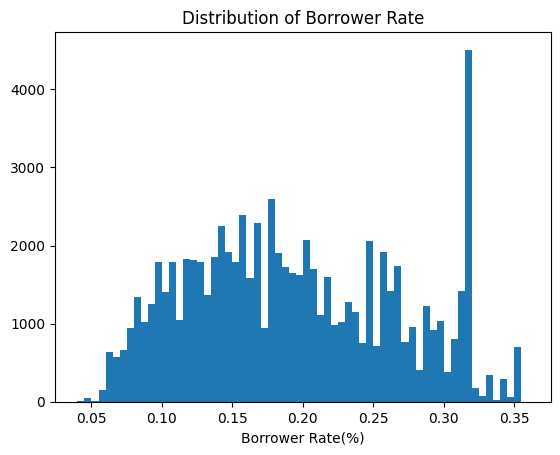

In [4]:
bins = np.arange(loan_df['BorrowerRate'].min(), loan_df['BorrowerRate'].max()+0.005, 0.005)
plt.hist(data=loan_df, x='BorrowerRate', bins=bins)
plt.xlabel('Borrower Rate(%)')
plt.title('Distribution of Borrower Rate');

## Distribution of Listing Category

Majority of the borrowers took loans for Debt consolidation. Only few borrowers took loans for business or medicals which are 4.7% and 1.8% respectively.

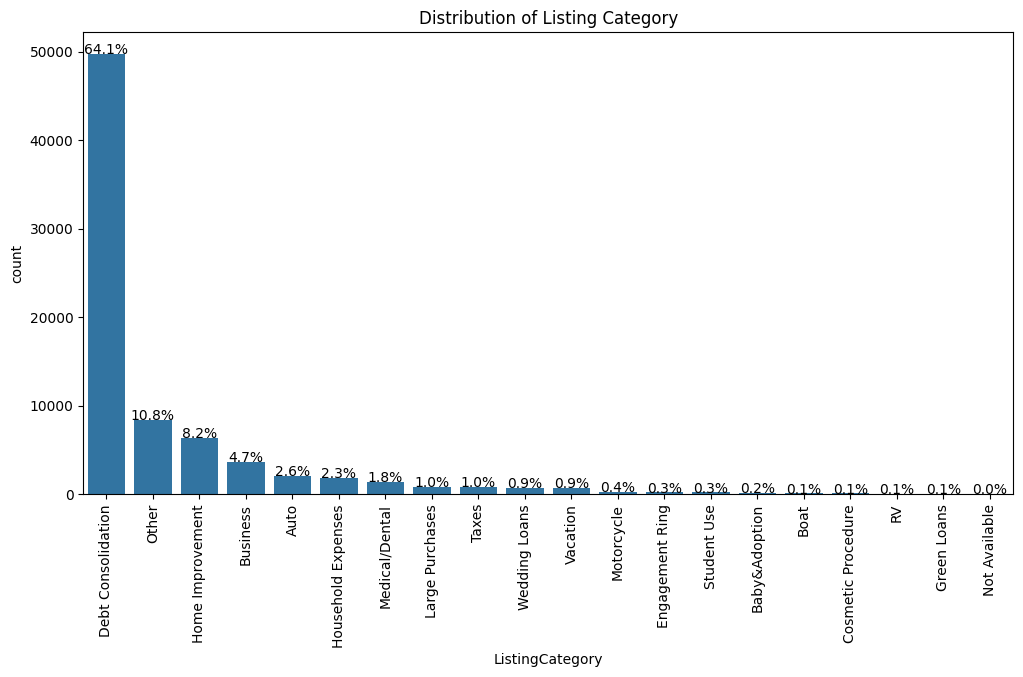

In [5]:
#configuring the figure size
plt.figure(figsize = [12,6])

#getting the unique value in ListingCategory
#and returning the frequenct in decending order
category_type = loan_df['ListingCategory'].value_counts()
category_order = category_type.index

#generate the sum of all the values in ListingCategory
List_val = loan_df['ListingCategory'].value_counts().sum()

#print the text (proportion) below the bars
base_color = sb.color_palette()[0]
sb.countplot(data=loan_df, x='ListingCategory', 
             color=base_color, order=category_order);


# Recalculating the category_order.
category_order = loan_df['ListingCategory'].value_counts()

# getting the tick  location and orientation
locs, labels = plt.xticks(rotation=90) 

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = category_type[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/List_val)

    # print the annotation just below the top of the bar
    plt.text(loc, count+2, pct_string, ha = 'center', color = 'black')
    
plt.title('Distribution of Listing Category');

## Effect of Borrower Rate and Prosper Score on Loan Status Outcome

Borrowers with positive Loan Status outcome(Completed, Current, Final Payment In Progress) have lower Interest Rate and higher ProsperScore than borrowers with negative loan status outcome(Chargeoff, Defaulted, PastDue). High Prosper Score observed in borrowers with positive Loan Status outcome is responsible for their lower borrower rate.

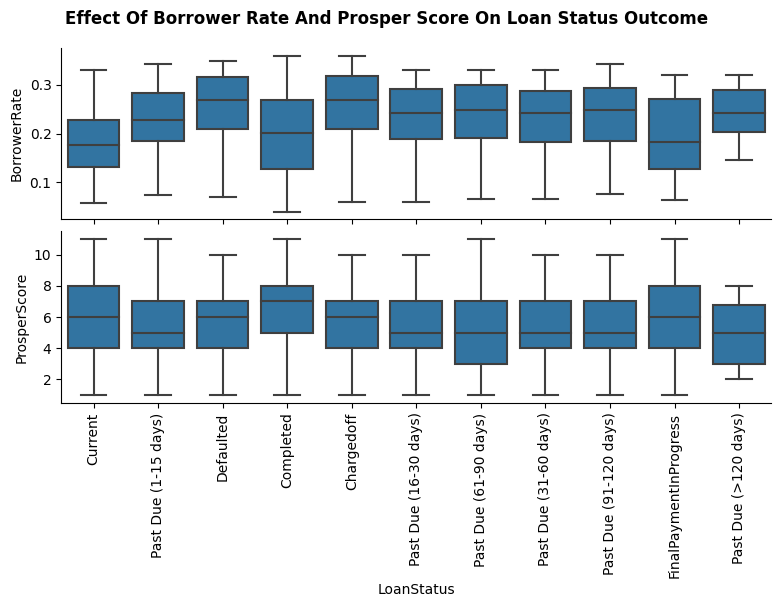

In [6]:
def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x=x, y=y, color=default_color)
    
g = sb.PairGrid(data= loan_df, y_vars= ['BorrowerRate', 'ProsperScore'], 
                x_vars= ['LoanStatus'], height=2, aspect=3)
plt.xticks(rotation=90, fontsize=10)
g.map(boxgrid)
plt.suptitle('Effect of Borrower Rate and Prosper Score on Loan Status Outcome'.title(), y=1, fontsize=12, weight='bold')
g.fig.set_size_inches(8, 6)
g.tight_layout()
plt.show();

## Effect of Prosper Score, Credit Score on Borrowers Rate

Borrowers with high ProsperScore and CreditScore have a lower Interest or Borrower Rate on their Loans. The higher the ProsperScore and CreditScore the lower the BorrowerRate.

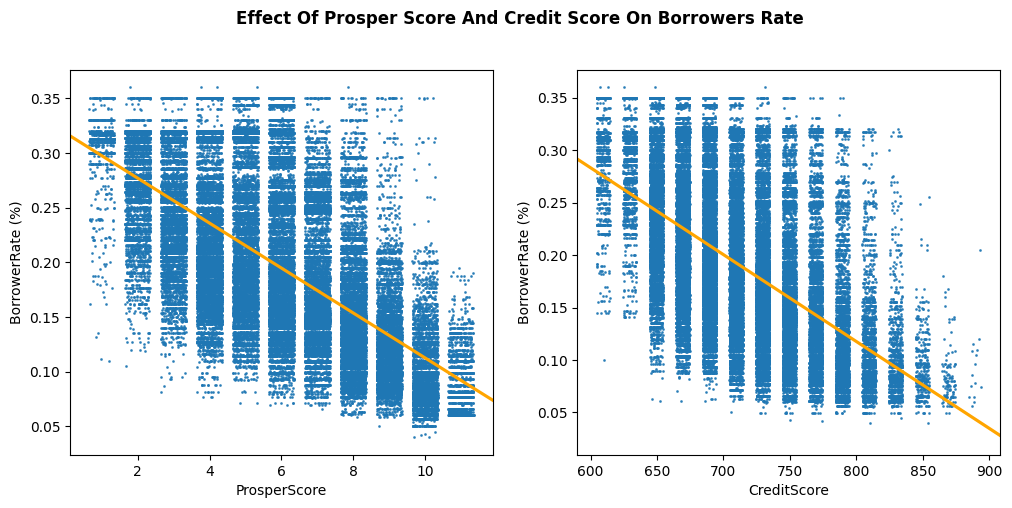

In [7]:
plt.figure(figsize=[12, 5])

# First Plot
plt.subplot(1,2,1)
sb.regplot(data=loan_df, x= 'ProsperScore', y='BorrowerRate', 
           truncate= False, x_jitter=0.35, scatter_kws={'s': 1}, line_kws= {'color': 'orange'})
plt.ylabel('BorrowerRate (%)');

# Second Plot
plt.subplot(1,2,2)
sb.regplot(data=loan_df, x= 'CreditScore', y='BorrowerRate', truncate= False, x_jitter=5, 
           scatter_kws={'s': 1}, line_kws= {'color': 'orange'})
plt.ylabel('BorrowerRate (%)')
plt.suptitle('Effect of Prosper Score and Credit Score on Borrowers Rate'.title(), y=1, fontsize=12, weight='bold');

## Effect of Prosper Rating on the Loan Amount

Borrowers with ProsperRating(AA , A, B) have more chances to be awarded a larger loan amount than other Borrowers. There was a downward steep from B to C to HR. The sudden change in loan amount from B to C appears that only Borrowers with Prosper Rating from B to AA qualifies for Larger Loan Amount.

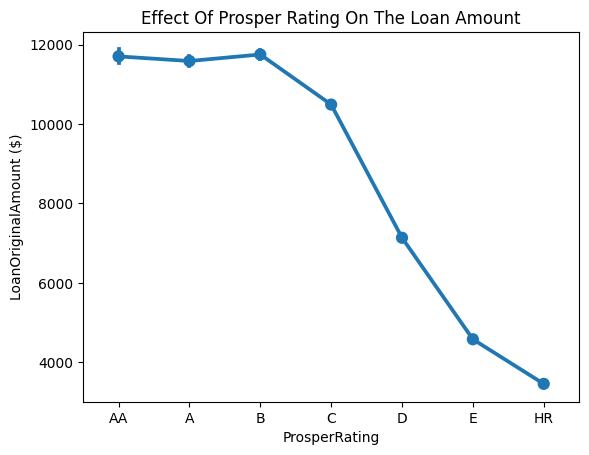

In [8]:
sb.pointplot(data=loan_df, x='ProsperRating', y= 'LoanOriginalAmount')
plt.ylabel('LoanOriginalAmount ($)')
plt.title('Effect of Prosper Rating on the Loan Amount'.title());

##  Effect of ProsperScore and CreditScore on BorrowerRate

The higher the Prosper Score and the Credit Score the lower the BorrowerRate.

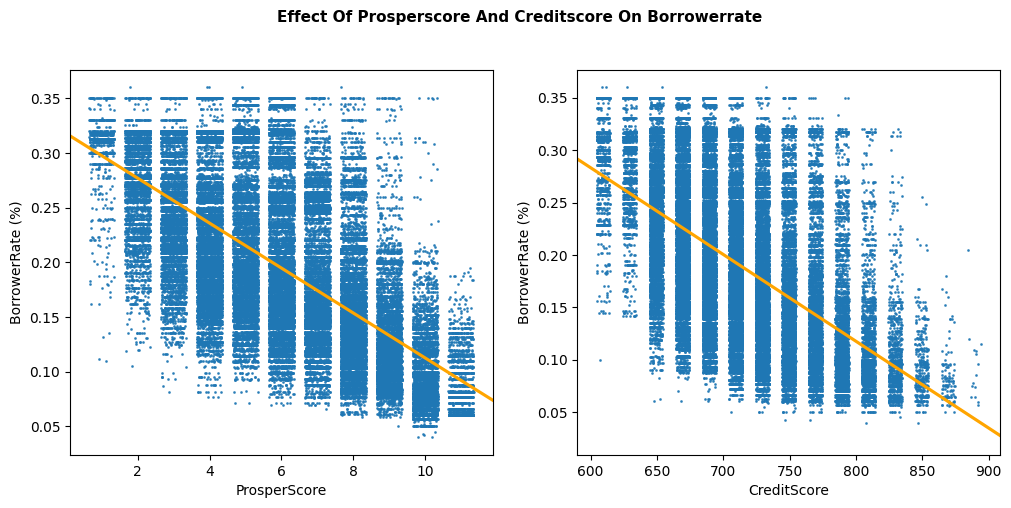

In [9]:
plt.figure(figsize=[12, 5])

# First Plot
plt.subplot(1,2,1)
sb.regplot(data=loan_df, x= 'ProsperScore', y='BorrowerRate', 
           truncate= False, x_jitter=0.35, scatter_kws={'s': 1}, line_kws= {'color': 'orange'})
plt.ylabel('BorrowerRate (%)');

# Second Plot
plt.subplot(1,2,2)
sb.regplot(data=loan_df, x= 'CreditScore', y='BorrowerRate', truncate= False, x_jitter=5, 
           scatter_kws={'s': 1}, line_kws= {'color': 'orange'})
plt.ylabel('BorrowerRate (%)')
plt.suptitle('Effect of ProsperScore and CreditScore on BorrowerRate'.title(), y=1, fontsize=11, weight='bold');

## Effect of ProsperRating on Loan Amount, BorrowerRate and LenderYield

Loan Amount reduces as Prosper Rating reduce from AA to HR. The higher the Prosper Rating the lower the Borrowers Rate and Lenders Yield. Borrowers with High Prosper Rating acquired larger loan amount and resulted in lesser yield to Lenders because of their lower Borrower Rate.

<Figure size 1500x1000 with 0 Axes>

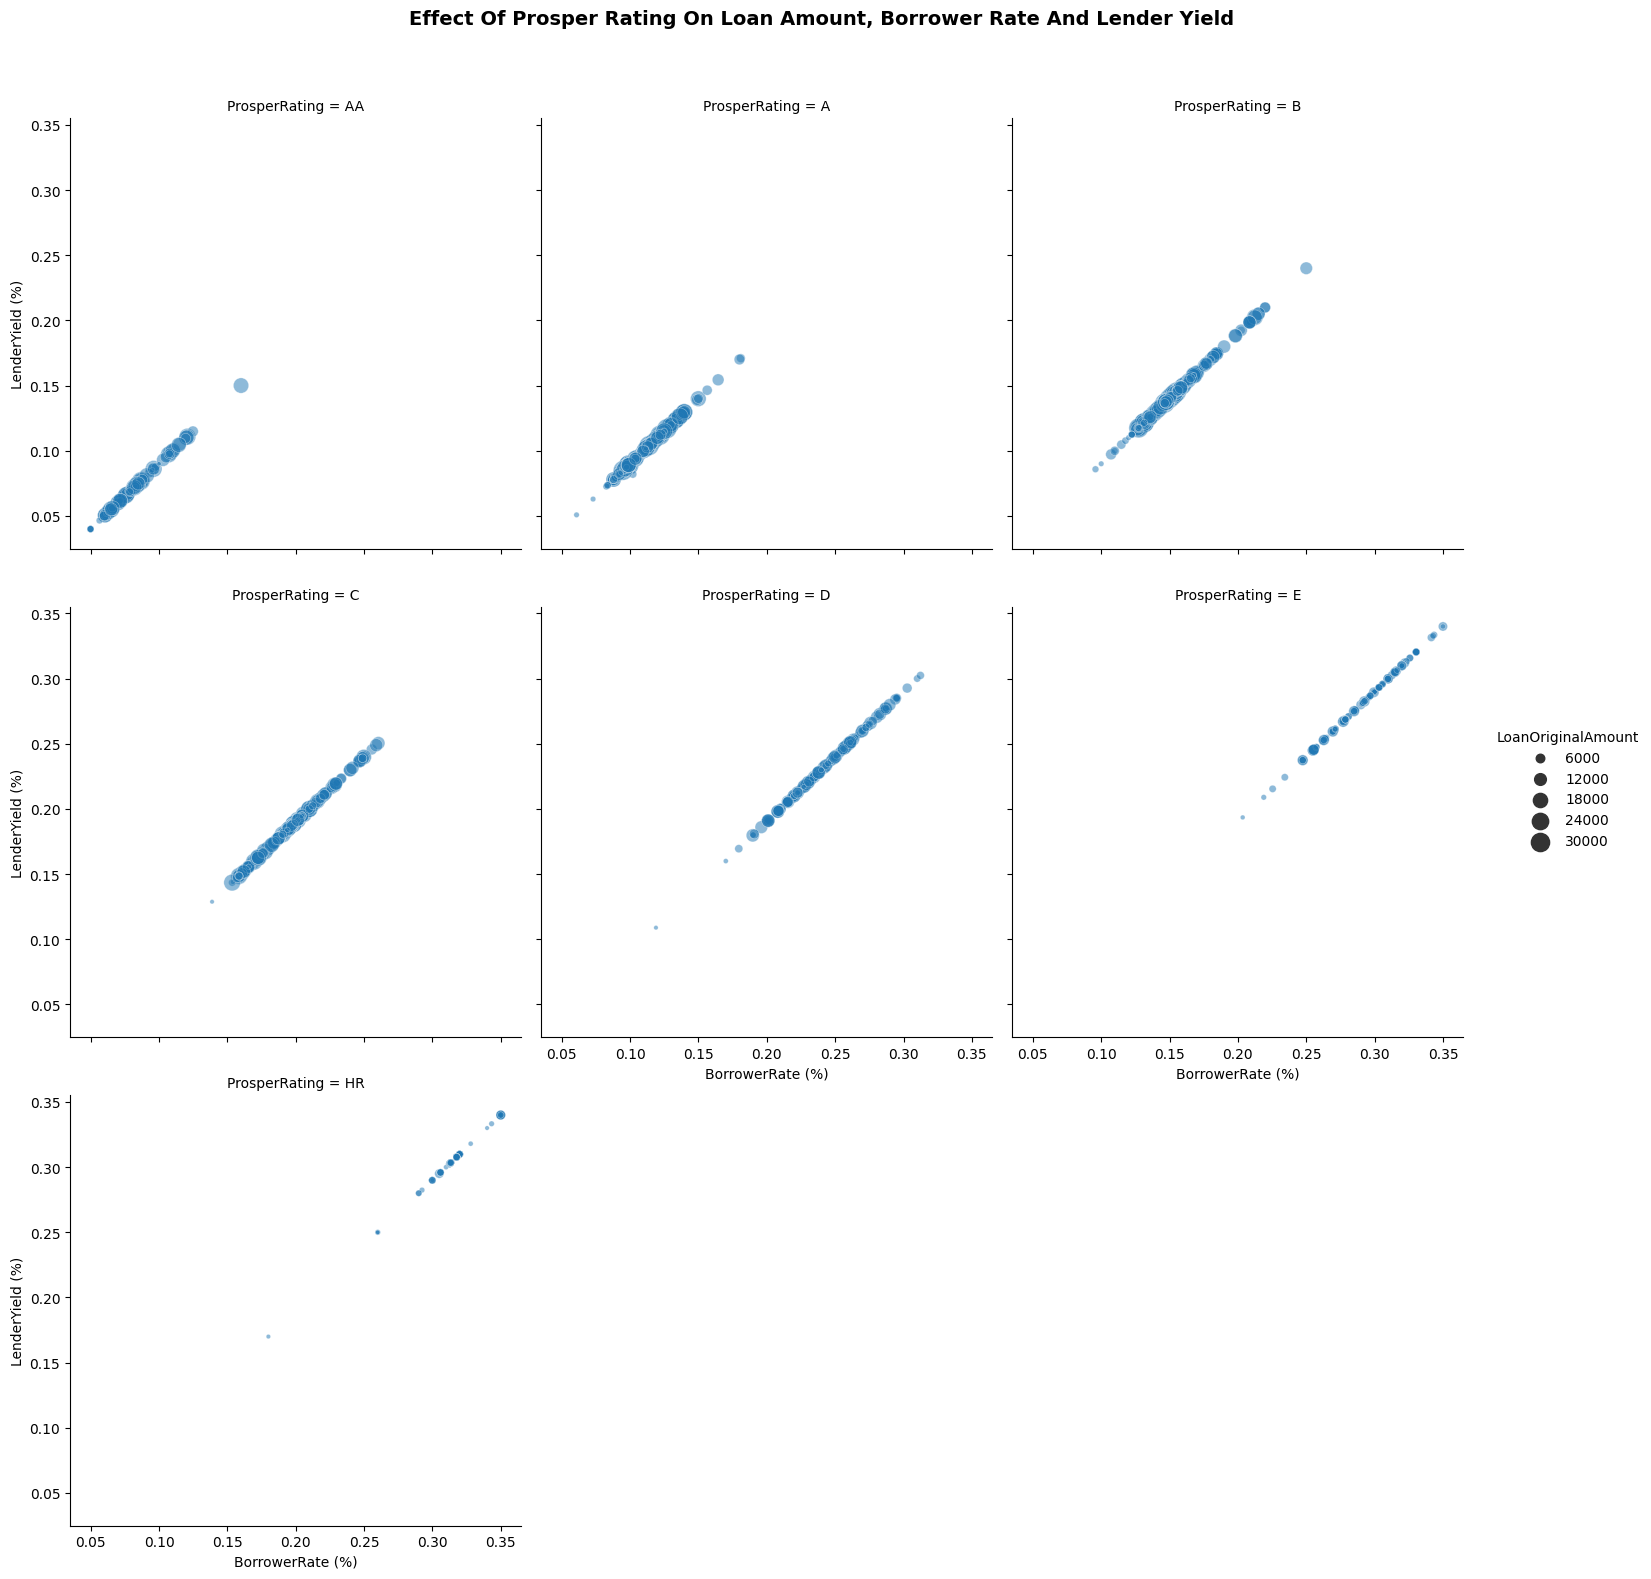

In [10]:
# Set figure size
plt.figure(figsize= [15, 10]);

# sample 2000 loans so that plots are clearer and they render faster
loan_sample =loan_df.sample(n=2000, replace=False)

# plot
g = sb.relplot(data=loan_sample, x='BorrowerRate', y= 'LenderYield',
            size='LoanOriginalAmount', sizes=(10, 200), 
           alpha= 0.5,col_wrap=3, col='ProsperRating', aspect=1)
g.set_ylabels('LenderYield (%)', clear_inner=False)
g.set_xlabels('BorrowerRate (%)')
g.tight_layout()
plt.suptitle('effect of Prosper Rating on Loan Amount, Borrower Rate and Lender Yield'.title(),
             y=1.05, fontsize=14, weight='bold');

## Effect of Borrower Rate and Lender Yield on Estimated Loss

Loans with high Borrower Rate and Lender Yield incured the highest Loss. The higher the Borrower Rate and Lender Yield on each loans the higher the chances of the loan resulting in a loss.

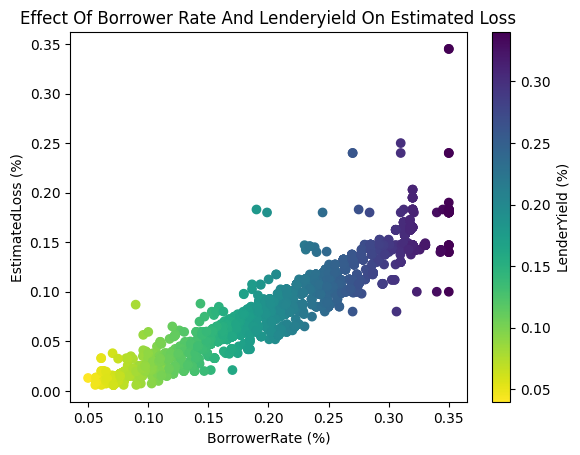

In [11]:
# sample 3000 loans so that plots are clearer and they render faster
loan_sample =loan_df.sample(n=3000, replace=False)

# create plot
plt.scatter(data=loan_sample, x='BorrowerRate', y= 'EstimatedLoss',
            c='LenderYield', cmap='viridis_r')
plt.colorbar(label= 'LenderYield (%)')
plt.xlabel('BorrowerRate (%)')
plt.ylabel('EstimatedLoss (%)')
plt.title('effect of Borrower Rate and LenderYield on Estimated Loss'.title());

>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

In [ ]:
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt